# <en><center>__California Housing Price Analysis__</center></en>

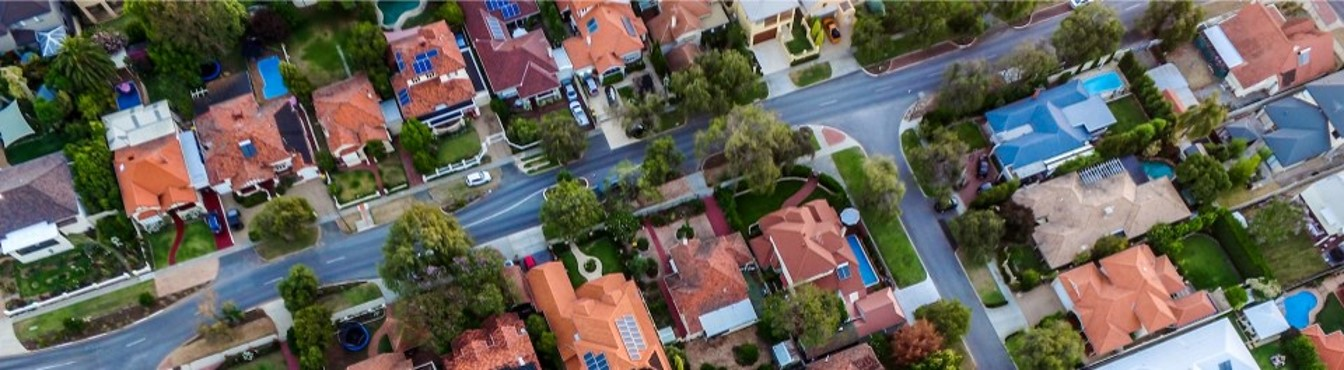

## <en><center>Frantz Alexander</center></en>

#### <en><center>December 23, 2022</center></en>

### <en><center>Project Introduction</center></en>

The analysis consists of predicting house value based on location and distance to the coastline.

# <en><center>Libraries</center></en>

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

sns.set_style("ticks")
%matplotlib inline

***

# <en><center>Prepare Data</center></en>

## Import Data

In [43]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Drop High Multicollinearity columns
    drop_columns = ["Tot_Bedrooms", "Population", "Households"]
    
    # Drop High Multicollinearity features Distance to city columns
    city_columns = [
        "Distance_to_LA", 
        "Distance_to_SanDiego", 
        "Distance_to_SanJose", 
        "Distance_to_SanFrancisco"
    ]
    drop_columns.extend(city_columns)
    
    # Drop leaky columns
    drop_columns.append("Median_Income")
    
    # Drop columns
    df.drop(columns = drop_columns,  inplace = True)
    
    # Remove outliers to "Median_House_Value"
    low, high = df["Tot_Rooms"].quantile([0.1, 0.9])
    mask_rooms = df["Tot_Rooms"].between(low, high)
    
    low_, high_ = df["Median_House_Value"].quantile([0.1, 0.9])
    mask_price = df["Median_House_Value"].between(low_, high_)
    
    df = df[mask_rooms & mask_price]
    
    
    return df

In [44]:
df = wrangle("California_Houses.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13215 entries, 2 to 20639
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Median_House_Value  13215 non-null  float64
 1   Median_Age          13215 non-null  int64  
 2   Tot_Rooms           13215 non-null  int64  
 3   Latitude            13215 non-null  float64
 4   Longitude           13215 non-null  float64
 5   Distance_to_coast   13215 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 722.7 KB


,Median_House_Value,Median_Age,Tot_Rooms,Latitude,Longitude,Distance_to_coast
2,352100.0,52,1467,37.85,-122.24,8259.085109
3,341300.0,52,1274,37.85,-122.25,7768.086571
4,342200.0,52,1627,37.85,-122.25,7768.086571
6,299200.0,52,2535,37.84,-122.25,6843.020847
7,241400.0,52,3104,37.84,-122.25,6843.020847


Display of the original columns in the dataset.

In [5]:
for col in df.columns:
    print(col)

Median_House_Value
Median_Income
Median_Age
Tot_Rooms
Tot_Bedrooms
Population
Households
Latitude
Longitude
Distance_to_coast
Distance_to_LA
Distance_to_SanDiego
Distance_to_SanJose
Distance_to_SanFrancisco


***

## Data Exploration

#### Displaying the Number of Unique Values in each Feature for Cardinality

In [7]:
df.nunique()

Median_House_Value           2818
Median_Income               10449
Median_Age                     52
Tot_Rooms                    5496
Tot_Bedrooms                 1865
Population                   3754
Households                   1759
Latitude                      777
Longitude                     770
Distance_to_coast            9999
Distance_to_LA               9999
Distance_to_SanDiego         9999
Distance_to_SanJose          9999
Distance_to_SanFrancisco     9999
dtype: int64

#### Checking the Presence of Null Values

In [6]:
df.isnull().sum()

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64

---

#### Checking for Data Leakage

In [13]:
df["Median_House_Value"].corr(df["Median_Income"])

0.6897753634102456

Key Insights:

- Median Income is highly correlated with the Median House Value.
- It also presents issues with data leakage.

---

#### Visualization of the Correlation Matrix

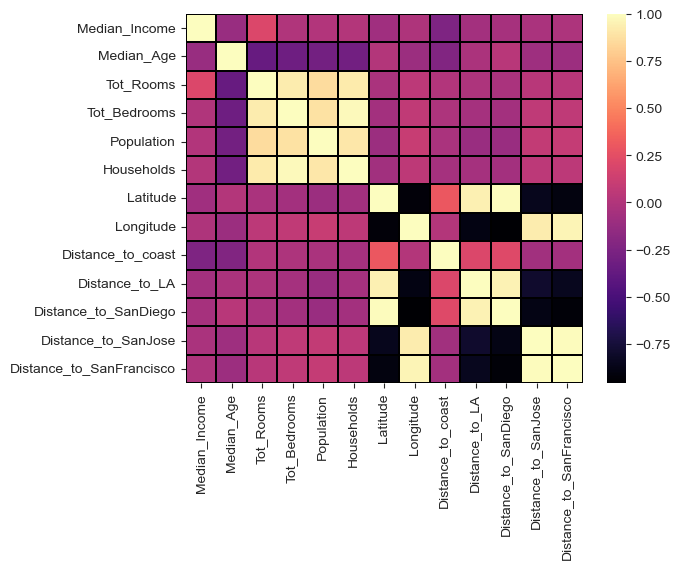

In [90]:
corr = df.drop(columns = "Median_House_Value").corr()
sns.heatmap(
    corr,
    cmap = "magma",
    linecolor = "black",
    linewidths = 0.1
);

There are features that present issues with multicollinearity

For a more robust analysis the following features would be removed:
    
    House Size characteristics:
        - Total Bedrooms
        - Population
        - Households
    
    Distance to City:
        - Distance to Los Angeles
        - Distance to San Diego
        - Distance to San Jose
        - Distance to San Francisco
    
    

---

#### Examining the Descriptive Charateristics of the Median House Value Feature

In [22]:
df["Median_House_Value"].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: Median_House_Value, dtype: float64

Key Insights:

The distribution is positively skewed.

There is the presence of a significant number of outliers in the median house value.

- The 75th percentile is at $264,000.

- The highest data point is at $500,000.

- The lowest data point is at $15,000.

#### Visualizing the Distribution of Median House Values

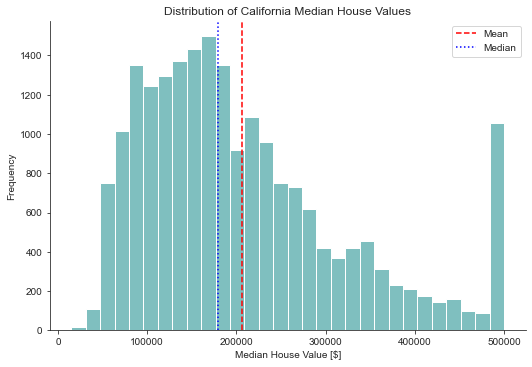

In [36]:
sns.displot(
    df["Median_House_Value"], 
    bins = 30,
    aspect = 1.5,
    color = "teal",
    alpha = 0.5
)
plt.axvline(
    np.mean(df["Median_House_Value"]),
    ls = "--",
    label = "Mean",
    color = "red"
    
)
plt.axvline(
    np.median(df["Median_House_Value"]),
    ls = ":",
    label = "Median",
    color = "blue"
)
plt.xlabel("Median House Value [$]")
plt.ylabel("Frequency")
plt.title("Distribution of California Median House Values")
plt.legend();

#### Visualizing the Distribution of Median House Values after removing outliers

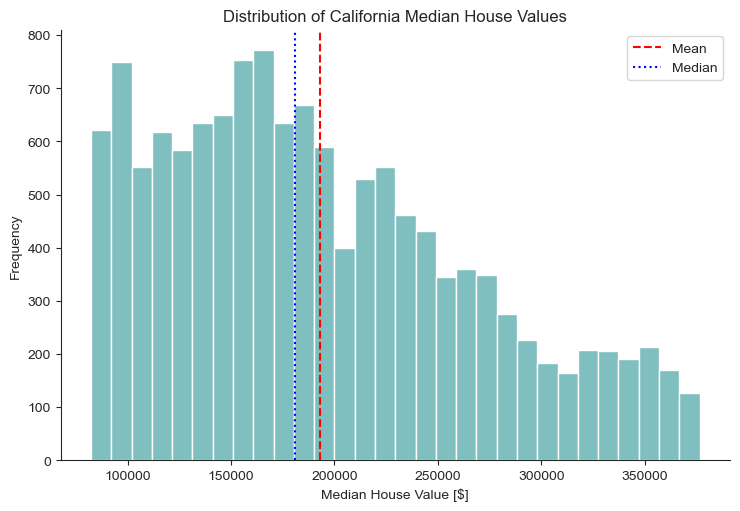

In [4]:
sns.displot(
    df["Median_House_Value"], 
    bins = 30,
    aspect = 1.5,
    color = "teal",
    alpha = 0.5
)
plt.axvline(
    np.mean(df["Median_House_Value"]),
    ls = "--",
    label = "Mean",
    color = "red"
    
)
plt.axvline(
    np.median(df["Median_House_Value"]),
    ls = ":",
    label = "Median",
    color = "blue"
)
plt.xlabel("Median House Value [$]")
plt.ylabel("Frequency")
plt.title("Distribution of California Median House Values")
plt.legend();

---

#### Visualizing the Distribution of Total Neighborhood Rooms

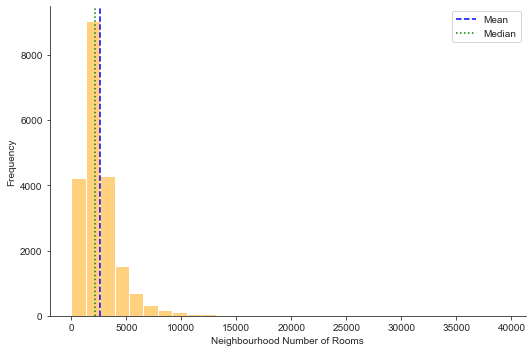

In [37]:
sns.displot(
    df["Tot_Rooms"],
    color = "orange",
    bins = 30,
    aspect = 1.5,
    alpha = 0.5
)

plt.axvline(
    np.mean(df["Tot_Rooms"]),
    color = "blue",
    ls = "--",
    label = "Mean"
)

plt.axvline(
    np.median(df["Tot_Rooms"]),
    color = "green",
    ls = ":",
    label = "Median"
)
plt.xlabel("Neighbourhood Number of Rooms")
plt.ylabel("Frequency")
plt.legend();

#### Visualizing the Distribution of Total Neighborhood Rooms after the removal of outliers

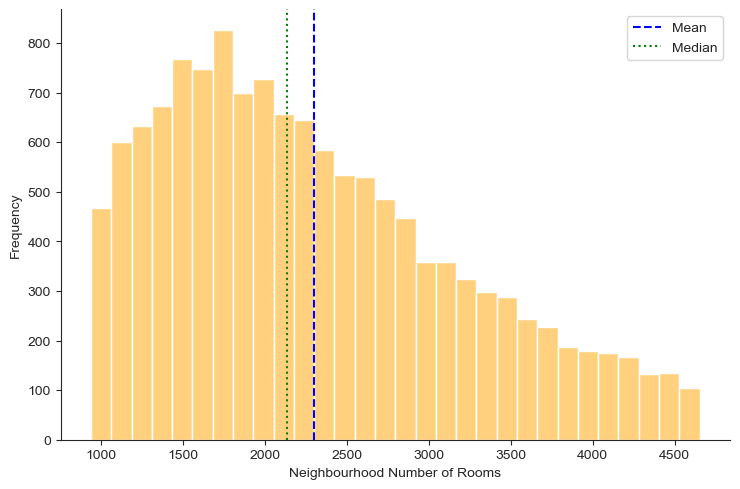

In [5]:
sns.displot(
    df["Tot_Rooms"],
    color = "orange",
    bins = 30,
    aspect = 1.5,
    alpha = 0.5
)

plt.axvline(
    np.mean(df["Tot_Rooms"]),
    color = "blue",
    ls = "--",
    label = "Mean"
)

plt.axvline(
    np.median(df["Tot_Rooms"]),
    color = "green",
    ls = ":",
    label = "Median"
)
plt.xlabel("Neighbourhood Number of Rooms")
plt.ylabel("Frequency")
plt.legend();

---

#### Visualizing the relationship between Neighborhood Total Rooms with Median House Value and with a 10% sample size

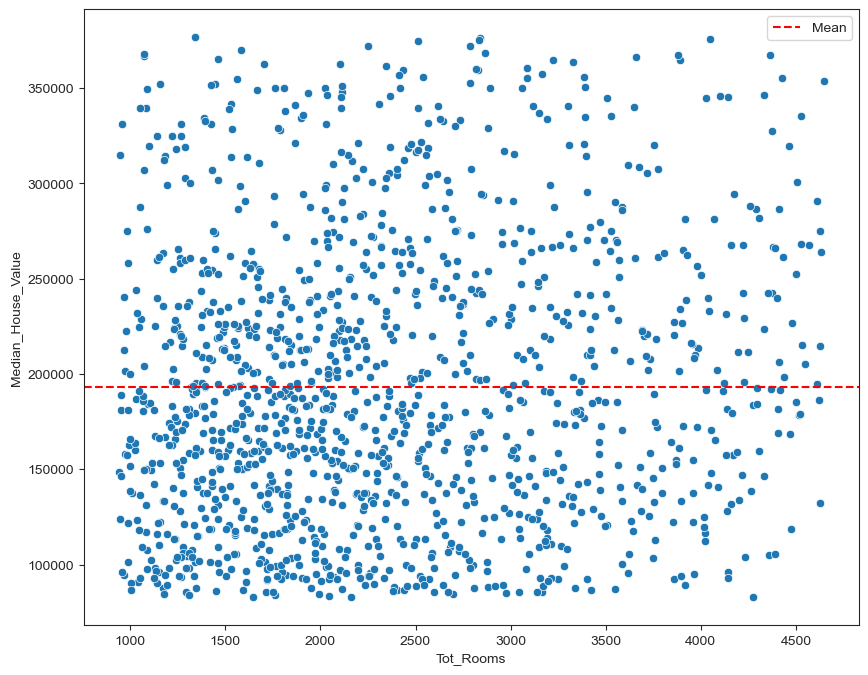

In [46]:
plt.figure(figsize = (10, 8))
sns.scatterplot(
    data = df.sample(frac = 0.1),
    x = "Tot_Rooms",
    y = "Median_House_Value",
)
plt.axhline(
    np.mean(df["Median_House_Value"]),
    ls = "--",
    label = "Mean",
    color = "red"
)
plt.legend();

#### Visusalizing the distributions of Total Rooms with Median House Value with Histogram heatmap.

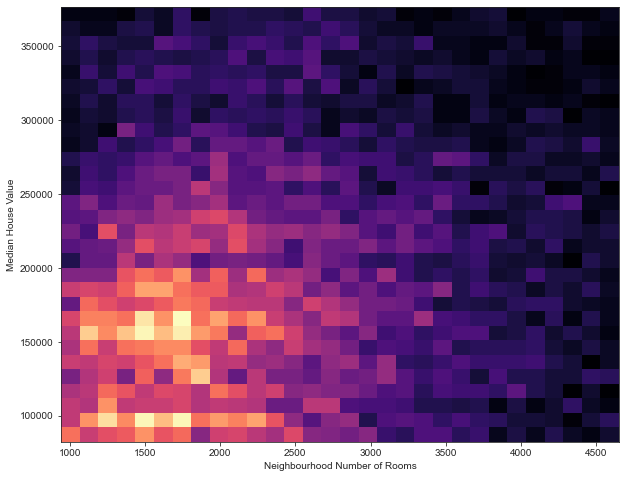

In [ ]:
plt.figure(figsize = (10,8))

plt.hist2d(df["Tot_Rooms"], df["Median_House_Value"], bins = 30, cmap = "magma")
plt.xlabel("Neighbourhood Number of Rooms")
plt.ylabel("Median House Value");

Key Insights

- There is a high concentration of neighborhoods in the bottom left corner.
- Few neighborhoods with median valuations above 300,000.
- Few neighborhoods with total number of rooms above 3000.


---

#### Visualizing the Relationship between Median House Value with Map Location

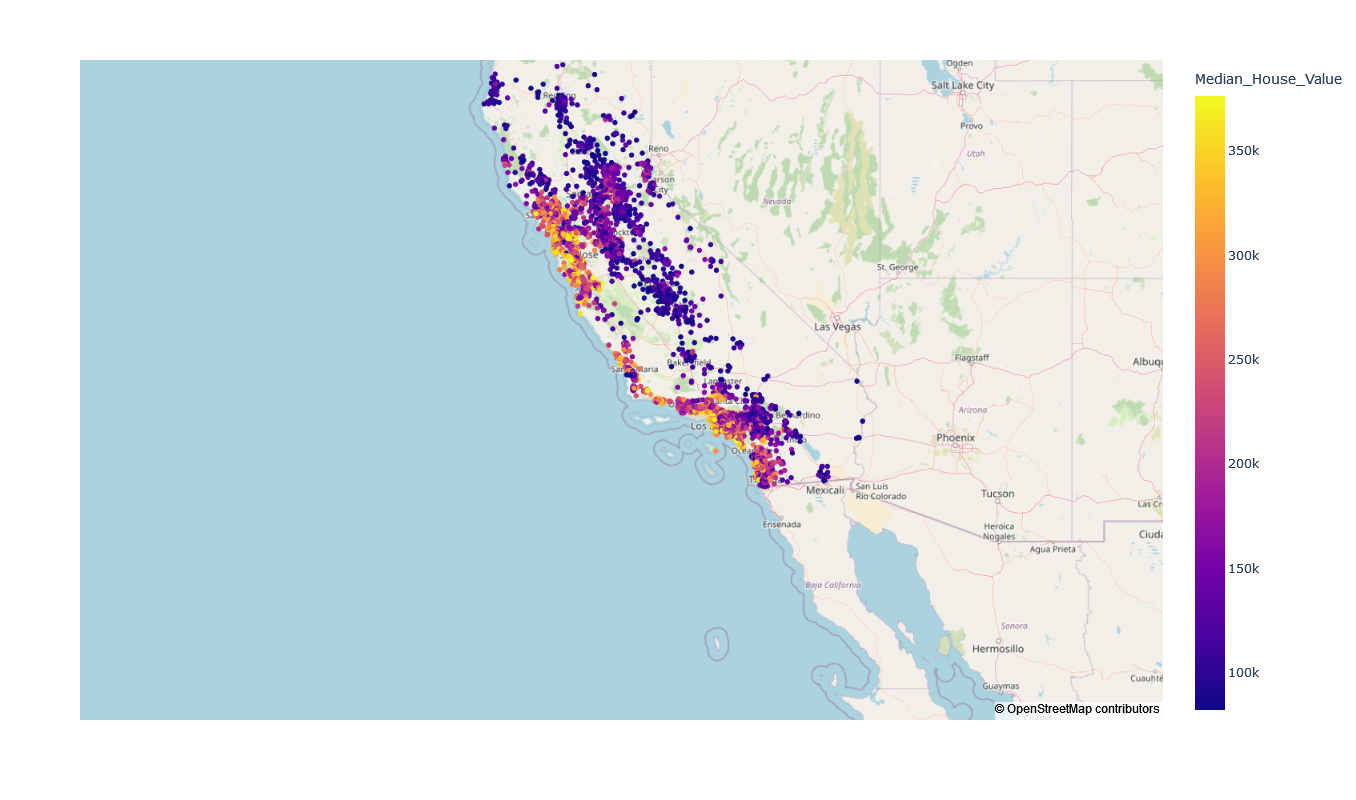

In [29]:
fig = px.scatter_mapbox(
    df,
    lat = "Latitude",
    lon = "Longitude",
    width = 800,
    height = 800,
    color = "Median_House_Value",
    hover_data = ["Median_House_Value"]
)
fig.update_layout(mapbox_style = "open-street-map")
fig.show()

#### Visualizing the relationship between House Value and Location

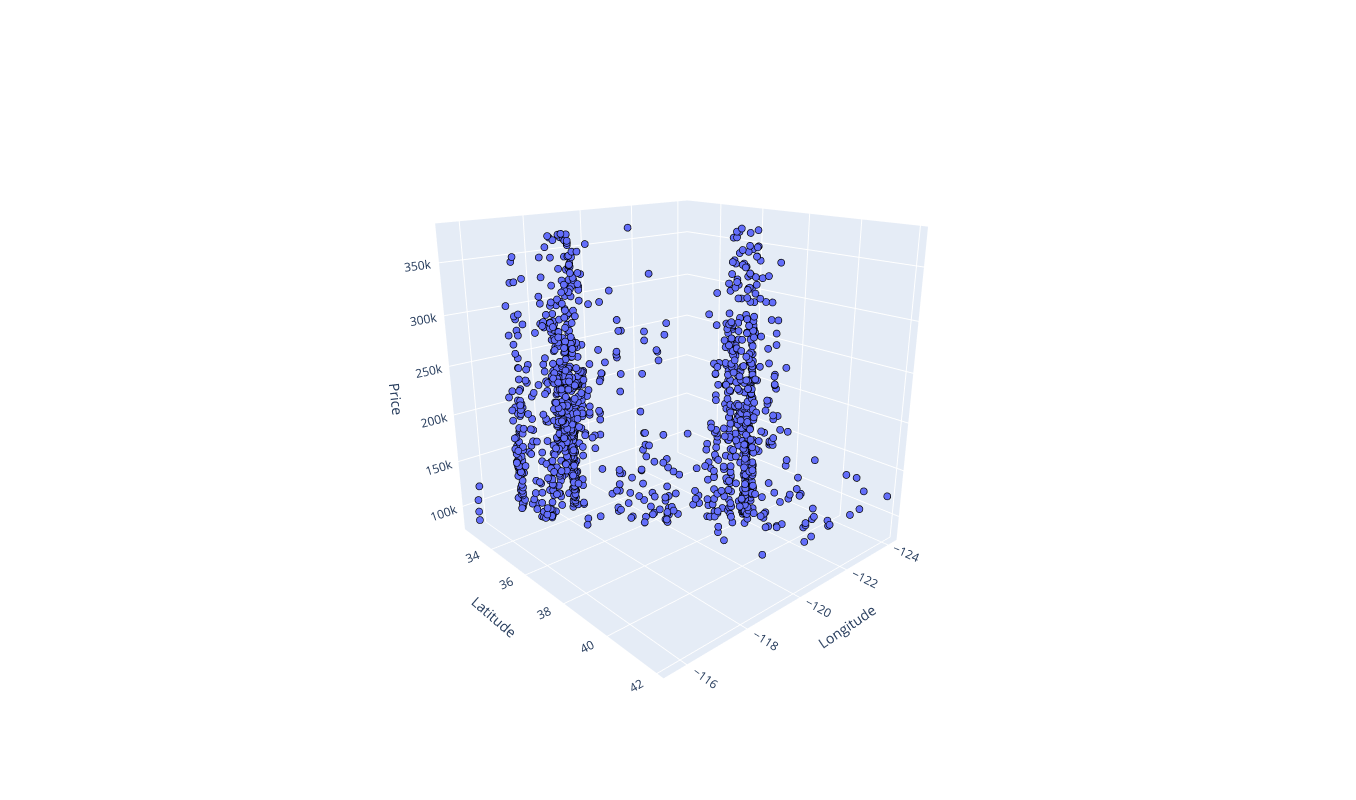

In [33]:
fig = px.scatter_3d(
    df.sample(frac = 0.1),
    x = "Longitude",
    y = "Latitude",
    z = "Median_House_Value",
    labels = {"Longitude": "Longitude", "Latitude": "Latitude", "Median_House_Value": "Price"},
    width = 800,
    height = 800
)

fig.update_traces(
    marker = {"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector = {"mode": "markers"}
)
# Display Figure
fig.show()

---

## Train-Test Split

#### The dataset would be split 80% for training the model and 20% for testing.

In [47]:
target = "Median_House_Value"

X = df.drop(columns = "Median_House_Value")
y = df[target]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2, 
    random_state = 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (10572, 5)
y_train shape: (10572,)
X_test shape: (2643, 5)
y_test shape: (2643,)


---

# <en><center>Model Building</center></en>

## Baseline

#### Calculate the Baseline Mean Absolute Error Metric

In [58]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean House Value:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))


Mean House Value: 193781.95
Baseline MAE: 61085.84881229539


## Iterate

#### Instantiate and Fit Linear Regressor to Data

In [59]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

---

## Evaluation

#### Calculating Mean Absolute Error

In [60]:
y_pred_training = model.predict(X_train)
print("Training Mean Absolute Error:", mean_absolute_error(y_train, y_pred_training))

Training Mean Absolute Error: 52050.32157954953


In [61]:
y_pred_test = model.predict(X_test)
print("Test Mean Absolute Error:", mean_absolute_error(y_test, y_pred_test))

Test Mean Absolute Error: 54180.78200247434


Key Insight:

The model performed slightly worse on the test set in comparison to the performance on the training set. 

---

# <en><center>Communication</center></en>

### Extracting the Model Intercept and Coefficients

In [62]:
intercept = model.intercept_
coefficients = model.coef_
print("Coefficients length: ", len(coefficients))
print(coefficients[:5])

Coefficients length:  5
[ 3.88258058e+01  1.19008921e+01 -3.48889499e+04 -3.71993540e+04
 -2.14147262e-01]


#### Extracting Feature Importances

In [63]:
feature_names = model.feature_names_in_

In [64]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

Median_Age              38.825806
Tot_Rooms               11.900892
Latitude            -34888.949926
Longitude           -37199.354042
Distance_to_coast       -0.214147
dtype: float64

#### Equation of Linear Regression Model

In [65]:
print(f"price = {intercept.round(2)}")
for f,c in feat_imp.items():
    print(f"+ ({round(c,2)} * {f})")

price = -3035051.02
+ (38.83 * Median_Age)
+ (11.9 * Tot_Rooms)
+ (-34888.95 * Latitude)
+ (-37199.35 * Longitude)
+ (-0.21 * Distance_to_coast)


---

#### Saving model to a file

In [67]:
with open("linearreg_model_location_v1.pkl", "wb") as f:
    pickle.dump(model, f)

---

#### Key Takeaways:

- The Training Mean Absolute Error: 52050.32
- The Test Mean Absolute Error: 54180.78
- The most valuable neighborhoods were in cities especially along the coastline. 
- The highest concentrations of houses were in neighborhoods with fewer than 3000 rooms and below median values of $300,000.

- The most important features for determining the neighborhood value in order of importance: 
    1. Location 
    2. Median Age
    3. Number of rooms
    4. Distance to the coastline.

---

## <en><center>Thank You</center></en>